# Compañía de taxi Sweet Lift Taxi

La compañía Sweet Lift Taxi ha recopilado datos históricos sobre pedidos de taxis en los aeropuertos. Para atraer a más conductores durante las horas pico, necesitamos predecir la cantidad de pedidos de taxis para la próxima hora. Construye un modelo para dicha predicción.

La métrica RECM en el conjunto de prueba no debe ser superior a 48.


## Descripción de los datos

Los datos se almacenan en el archivo `taxi.csv`. 	
El número de pedidos está en la columna `num_orders`.

## Preparación

In [2]:
# importar librerias
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt 
from statsmodels.tsa.seasonal import seasonal_decompose
 
from sklearn.model_selection import train_test_split, TimeSeriesSplit, GridSearchCV

from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from lightgbm import LGBMRegressor

In [4]:
# cargar datos y establecer la columna 0 como datos de tipo datetime
taxi = pd.read_csv('/datasets/taxi.csv', index_col=[0], parse_dates=[0])

In [3]:
# Información general del dataframe
taxi.sort_index(inplace = True)
taxi.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 26496 entries, 2018-03-01 00:00:00 to 2018-08-31 23:50:00
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   num_orders  26496 non-null  int64
dtypes: int64(1)
memory usage: 414.0 KB


In [4]:
# Verificar si las fechas y horas están en orden cronológico
taxi.index.is_monotonic

True

In [5]:
#Vista previa
taxi.head(10)

,num_orders
datetime,
2018-03-01 00:00:00,9
2018-03-01 00:10:00,14
2018-03-01 00:20:00,28
2018-03-01 00:30:00,20
2018-03-01 00:40:00,32
2018-03-01 00:50:00,21
2018-03-01 01:00:00,7
2018-03-01 01:10:00,5
2018-03-01 01:20:00,17


Podemos ver que no hay presencia de datos nulos ni duplicados en el dataframe, sin embargo vamos a necesitar sumar los datos por día para poder hacer el análisis final.

## Análisis

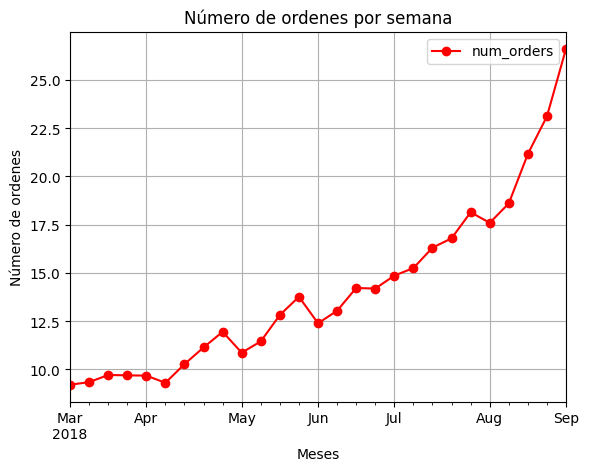

In [6]:
# Gráfica de número de pedidos promedio por semana
taxi_w = taxi.resample('1W').mean()
taxi_w.plot(
    marker= 'o', 
    title='Número de ordenes promedio por semana', 
    ylabel = 'Número de ordenes', 
    xlabel ='Meses', color='red').grid(True)

Observamos la cantidad promedio de ordenes va aumentando con el paso de las semanas

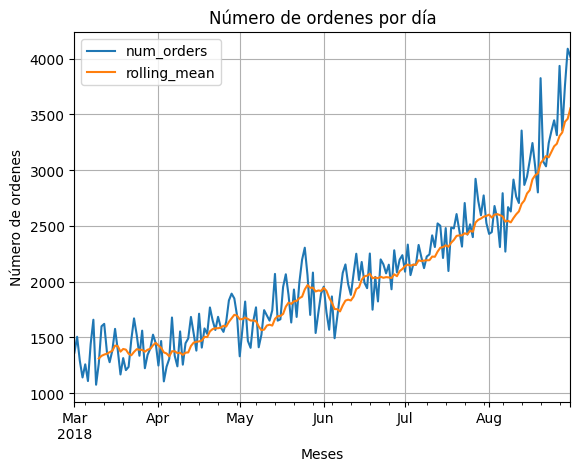

In [25]:
# Media móvil
taxi_d1 = taxi.resample('1D').sum()
taxi_d1['rolling_mean'] = taxi_d1.rolling(10).mean()
taxi_d1.plot(title= 'Número de ordenes por día', xlabel ='Meses', ylabel='Número de ordenes').grid(True)

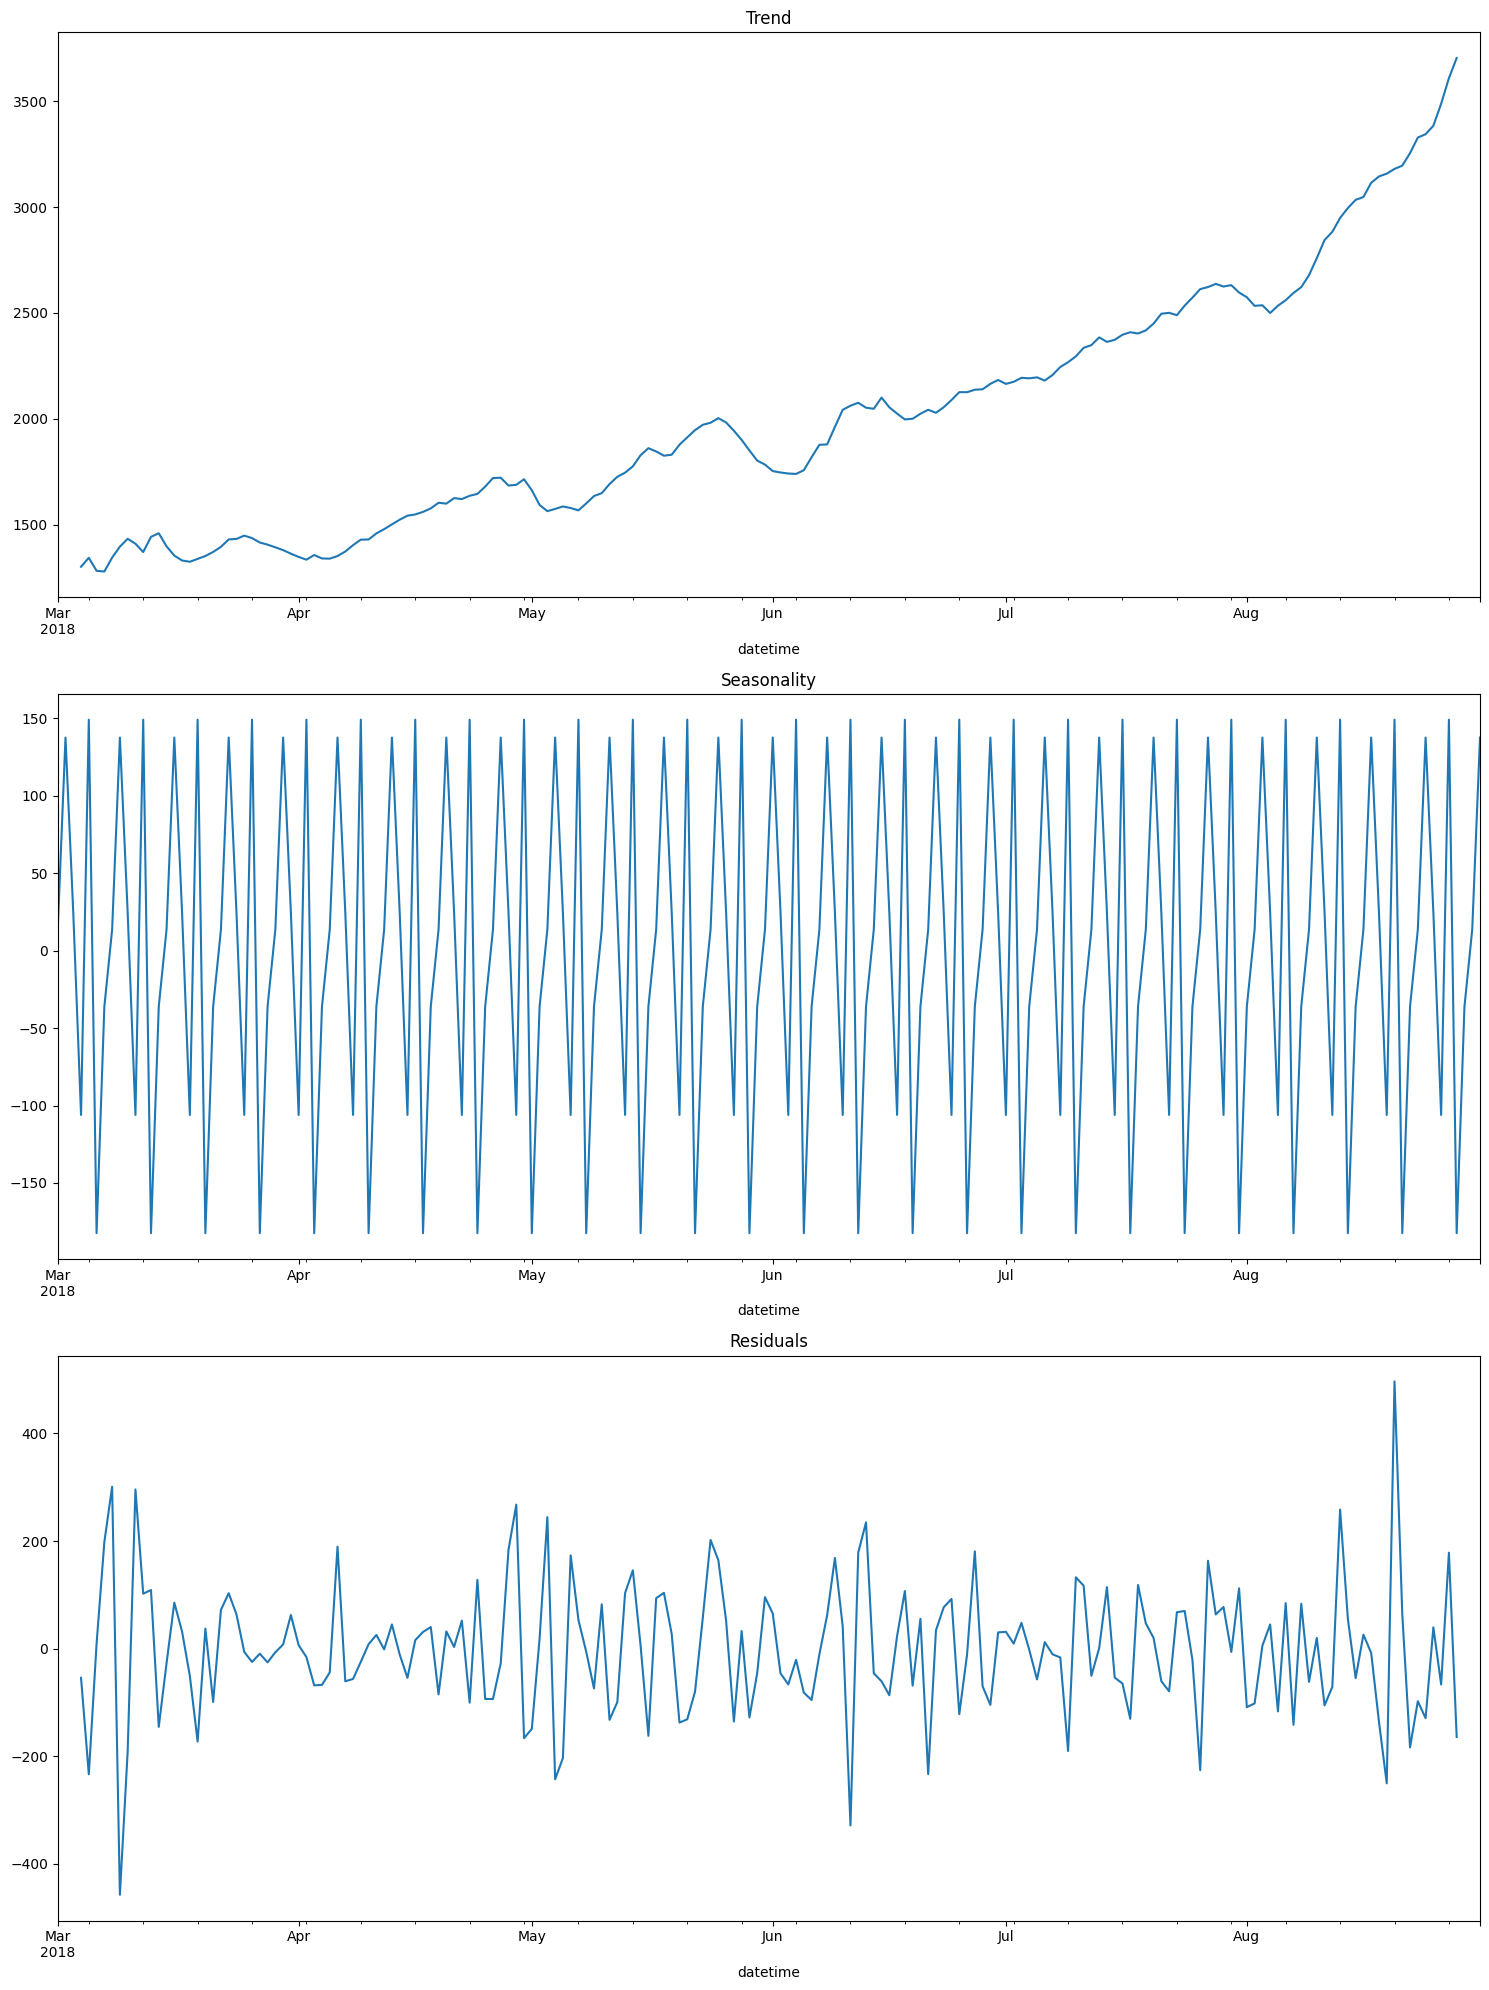

In [8]:
#Tendencia, estacionalidad y residuales
taxi_d = taxi.resample('1D').sum()
decomposed = seasonal_decompose(taxi_d)

plt.figure(figsize=(15, 20))
plt.subplot(311)
# Para mostrar el gráfico de manera correcta, especifica su
# eje ax igual a plt.gca() (gca = obtener el eje actual)
decomposed.trend.plot(ax=plt.gca())
plt.title('Trend')
plt.subplot(312)
decomposed.seasonal.plot(ax=plt.gca())
plt.title('Seasonality')
plt.subplot(313)
decomposed.resid.plot(ax=plt.gca())
plt.title('Residuals')
plt.tight_layout()

1. Podemos observar una tendencia al alza, conforme pasan los meses la cantidad de pedidos aumentan.
2. La gráfica de residuales nos muestra los valores atípicos, dónde resaltan dos importantes, uno en el mes de marzo y otro en el mes de agosto.
3. Podemos ver en el gráfico de estacionalidad un patrón que se repite de forma cíclica cada semana

## Formación

In [9]:
# Suma de pedidos de taxis por hora
taxi1 = taxi.resample('1H').sum()

In [10]:
# Creación de características para el modelo 
def make_features(data, max_lag, rolling_mean_size):
    taxi1['year'] = taxi1.index.year
    taxi1['month'] = taxi1.index.month
    taxi1['day'] = taxi1.index.day
    taxi1['dayofweek'] = taxi1.index.dayofweek
    taxi1['hour'] =  taxi1.index.hour
    
    for lag in range(1, max_lag + 1):
        taxi1['lag_{}'.format(lag)] = taxi1['num_orders'].shift(lag)

    taxi1['rolling_mean'] = (
        taxi1['num_orders'].shift().rolling(rolling_mean_size).mean()
    )


make_features(taxi1, 6, 10)

# Vista general del data set con las características creadas
taxi1.head()

,num_orders,year,month,day,dayofweek,hour,lag_1,lag_2,lag_3,lag_4,lag_5,lag_6,rolling_mean
datetime,,,,,,,,,,,,,
2018-03-01 00:00:00,124,2018,3,1,3,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-01 01:00:00,85,2018,3,1,3,1,124.0,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-01 02:00:00,71,2018,3,1,3,2,85.0,124.0,NaN,NaN,NaN,NaN,NaN
2018-03-01 03:00:00,66,2018,3,1,3,3,71.0,85.0,124.0,NaN,NaN,NaN,NaN
2018-03-01 04:00:00,43,2018,3,1,3,4,66.0,71.0,85.0,124.0,NaN,NaN,NaN


In [11]:
# Eliminación de los valores ausentes
taxi1 = taxi1.dropna()

In [12]:
# División del conjunto de datos
train, test = train_test_split(taxi1, shuffle=False, test_size=0.1)

features_train = train.drop(['num_orders'], axis=1)
target_train = train['num_orders']
features_test = test.drop(['num_orders'], axis=1)
target_test = test['num_orders']

In [13]:
print('Conjunto de datos de entrenamiento: ', features_train.shape)
print('Conjunto de datos de prueba: ', features_test.shape)

Conjunto de datos de entrenamiento:  (3965, 12)
Conjunto de datos de prueba:  (441, 12)


In [14]:
# Nos aseguramos que la división se haya hecho de manera correcta

print(features_train.index.min(), features_train.index.max())
print(features_test.index.min(), features_test.index.max())

2018-03-01 10:00:00 2018-08-13 14:00:00
2018-08-13 15:00:00 2018-08-31 23:00:00


Los datos se desglosaron correctamente ya que el conjunto de entrenamiento finaliza el 13 de agosto a las 14:00hrs y el conjunto de prueba comienza el mismo día pero a las 15:00hrs

## Prueba

### Modelo de predicción constante

In [16]:
#Modelo de predicción constante con la mediana 

pred_median = np.ones(test.shape) * train['num_orders'].median()
print('RECM:', mean_squared_error(test, pred_median, squared = False))

RECM: 221.17136421921194


### Modelo de Regresión Lineal

In [17]:
model = LinearRegression()
model.fit(features_train, target_train)

pred_train = model.predict(features_train)
pred_test = model.predict(features_test)

print(
    'RECM para el conjunto de entrenamiento:', mean_squared_error(target_train, pred_train, squared = False)
)
print('RECM para el conjunto de prueba:', mean_squared_error(target_test, pred_test, squared = False))

RECM para el conjunto de entrenamiento: 30.476300709417533
RECM para el conjunto de prueba: 53.22439426529474


### Modelo de bosque aleatorio

In [18]:
#Encontramos los mejores parámetros para el modelo utilizando la grilla de hiperparámetros

param_grid = {'n_estimators': [2,4,6,8,10],'max_features': [ 'sqrt', 'log2'],'max_depth' : [2,4,6,8,10]}

model_rfr =RandomForestRegressor(random_state=12345)
grid_search_rfr = GridSearchCV(estimator=model_rfr, param_grid=param_grid, cv=5)

grid_search_rfr.fit(features_train, target_train)
grid_search_rfr.best_params_

{'max_depth': 10, 'max_features': 'sqrt', 'n_estimators': 10}

In [19]:
#Fijamos el modelo con parámetros óptimos
model_rfr =RandomForestRegressor(random_state=12345, max_depth=10, max_features='sqrt', n_estimators=10)

#Entrenamos el modelo
model_rfr.fit(features_train, target_train)

RandomForestRegressor(max_depth=10, max_features='sqrt', n_estimators=10,
                      random_state=12345)

In [20]:
#Predicciones para el conjunto de entrenamiento y de prueba
pred_train_rfr = model_rfr.predict(features_train)
pred_test_rfr = model_rfr.predict(features_test)

print(
    'RECM para el conjunto de entrenamiento:', mean_squared_error(target_train, pred_train_rfr, squared = False)
)
print('RECM para el conjunto de prueba:', mean_squared_error(target_test, pred_test_rfr, squared = False))

RECM para el conjunto de entrenamiento: 17.71977590924314
RECM para el conjunto de prueba: 53.27075369343548


### Modelo LGBM Regressor

In [21]:
# Encontramos los mejores parámetros para el modelo
param_ltb={'num_leaves':[10, 15, 20], 'learning_rate':[0.5, 0.1], 'n_estimators':[10, 20, 30]}

model_ltb = LGBMRegressor(random_seed=123456)
grid = GridSearchCV(estimator=model_ltb, param_grid=param_ltb, n_jobs=-1)

grid.fit(features_train, target_train)
grid.best_params_

{'learning_rate': 0.5, 'n_estimators': 20, 'num_leaves': 20}

In [22]:
# Fijamos el modelo con parámetros óptimos
model_lgbm = LGBMRegressor(random_seed=123456, learning_rate=0.5, n_estimators=20, num_leaves=20)

# Entrenamos el modelo
model_lgbm.fit(features_train, target_train)

LGBMRegressor(learning_rate=0.5, n_estimators=20, num_leaves=20,
              random_seed=123456)

In [23]:
# Predicciones en conjunto de entrenamiento y prueba
pred_train_lgbm = model_lgbm.predict(features_train) 
pred_test_lgbm = model_lgbm.predict(features_test) 
print(
    'RECM para el conjunto de entrenamiento:', mean_squared_error(target_train, pred_train_lgbm, squared = False)
)
print('RECM para el conjunto de prueba:', mean_squared_error(target_test, pred_test_lgbm, squared = False))

RECM para el conjunto de entrenamiento: 17.328789575016387
RECM para el conjunto de prueba: 42.694442027501324


## Conclusiones

Hemos podido crear diferentes modelos, los cuales van mejorando en cuando al resultado del RECM para el conjunto de prueba en comparación con el modelo constante.

Vemos que el modelo que tiene el menor valor de predicción para el conjunto de prueba es el de LGBM regressor, siendo de 42.69. Por lo tanto es el recomendado para ser usado.